# 43008: Reinforcement Learning

## Week 7: Temporal-Difference Methods for Continuous Control
## Part C: Q-Learning for Pendulum

This notebook will explore the implementation of a Temporal-Difference (TD) method, Q-Learning, adapted for the Pendulum environment from Gymnasium.

* Q-Learning Algorithm with discretization for continuous environments

### What you will learn?
* Implement Q-Learning for continuous state and action spaces
* Apply discretization techniques to the Pendulum environment
* Visualize and evaluate control performance on the inverted pendulum

# 43008: Reinforcement Learning

## Assignment 2: Q-Learning for Continuous Control
## Part C: Enhanced Q-Learning for Pendulum Environment

This notebook implements an advanced Q-Learning algorithm adapted for the continuous Pendulum environment from Gymnasium, using sophisticated discretization techniques.

* **Enhanced Q-Learning Algorithm** with high-resolution state space discretization
* **Continuous-to-Discrete Mapping** for both observation and action spaces
* **10,000+ State Space** for precise pendulum control

### What you will learn?
* Implement Q-Learning for continuous state and action spaces using discretization
* Design and apply advanced discretization techniques for the Pendulum environment
* Analyze and visualize control performance on the inverted pendulum task
* Compare different state space resolutions and their impact on learning

## 1. Imports and Utilities for Pendulum Q-Learning

This section imports all necessary libraries for implementing Q-Learning on the Pendulum environment, including:
- **Gymnasium** for the Pendulum-v1 environment
- **Visualization tools** for plotting learning curves and value functions
- **Video recording utilities** for capturing agent performance

In [126]:
!pip install gymnasium pyvirtualdisplay
!apt-get install -y xvfb ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [127]:
!pip install gymnasium[other]
!pip install gymnasium[toy-text]

In [128]:
import sys
import os
import gymnasium as gym
import numpy as np
import random
import glob
import io
import base64
from collections import namedtuple
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

### Utility Functions




#### Episode Statistics Plotting for Pendulum Training

In [129]:
# Function to plot the Episode statistics
# Adapted from: https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py

def plot_episode_stats(stats, smoothing_window=10, noshow=False):

    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [130]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class DiscretePendulumWrapper(gym.Wrapper):
    """
    Enhanced wrapper to discretize the continuous Pendulum environment with higher resolution.
    Converts continuous observation space to discrete bins and
    continuous action space to discrete actions.
    """

    def __init__(self, env, n_actions=15, cos_bins=20, sin_bins=20, theta_dot_bins=25):
        super().__init__(env)

        # Store bin counts
        self.cos_bins = cos_bins
        self.sin_bins = sin_bins
        self.theta_dot_bins = theta_dot_bins

        # Discretize action space (increased from 7 to 15 for finer control)
        self.n_actions = n_actions
        # Pendulum actions are torque values in [-2.0, 2.0]
        self.action_space = spaces.Discrete(n_actions)
        self.discrete_actions = np.linspace(-2.0, 2.0, n_actions)

        # Enhanced discretization of observation space with different resolutions
        # cos(theta) and sin(theta) are in [-1, 1] - higher resolution for angle
        # theta_dot is typically in [-8, 8] but can be wider - highest resolution for velocity
        self.obs_bins = [
            np.linspace(-1.0, 1.0, cos_bins + 1),      # cos(theta) - 20 bins
            np.linspace(-1.0, 1.0, sin_bins + 1),      # sin(theta) - 20 bins
            np.linspace(-8.0, 8.0, theta_dot_bins + 1) # theta_dot - 25 bins
        ]

        # Total discrete states: 20 × 20 × 25 = 10,000 states (10x more than before)
        total_states = cos_bins * sin_bins * theta_dot_bins
        self.observation_space = spaces.Discrete(total_states)

        print(f"Enhanced State Space: {cos_bins} × {sin_bins} × {theta_dot_bins} = {total_states:,} states")
        print(f"Action Space: {n_actions} discrete actions")

    def _discretize_observation(self, obs):
        """Convert continuous observation to discrete state index with enhanced precision."""
        cos_theta, sin_theta, theta_dot = obs

        # Clip theta_dot to reasonable bounds (extended range for better coverage)
        theta_dot = np.clip(theta_dot, -8.0, 8.0)

        # Find bin indices using np.digitize (returns 1-indexed, so subtract 1)
        cos_bin = np.digitize(cos_theta, self.obs_bins[0]) - 1
        sin_bin = np.digitize(sin_theta, self.obs_bins[1]) - 1
        theta_dot_bin = np.digitize(theta_dot, self.obs_bins[2]) - 1

        # Ensure bins are within valid range
        cos_bin = np.clip(cos_bin, 0, self.cos_bins - 1)
        sin_bin = np.clip(sin_bin, 0, self.sin_bins - 1)
        theta_dot_bin = np.clip(theta_dot_bin, 0, self.theta_dot_bins - 1)

        # Convert to single state index using a more efficient mapping
        state = (cos_bin * self.sin_bins * self.theta_dot_bins +
                sin_bin * self.theta_dot_bins +
                theta_dot_bin)

        return state

    def get_state_info(self, state):
        """Convert state index back to bin indices for debugging/visualization."""
        cos_bin = state // (self.sin_bins * self.theta_dot_bins)
        remainder = state % (self.sin_bins * self.theta_dot_bins)
        sin_bin = remainder // self.theta_dot_bins
        theta_dot_bin = remainder % self.theta_dot_bins
        return cos_bin, sin_bin, theta_dot_bin

    def step(self, action):
        # Convert discrete action to continuous action
        continuous_action = np.array([self.discrete_actions[action]])
        obs, reward, terminated, truncated, info = self.env.step(continuous_action)

        # Convert continuous observation to discrete state
        discrete_obs = self._discretize_observation(obs)

        return discrete_obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        discrete_obs = self._discretize_observation(obs)
        return discrete_obs, info

def epsilon_greedy_policy(Q, state, epsilon):
    """
    Creates an epsilon-greedy policy based on a given Q-table and epsilon.

    Args:
        Q: A numpy array that maps from state -> action values.
        state: The current state index.
        epsilon: The probability to select a random action. Float between 0 and 1.

    Returns:
        The selected action index.
    """
    nA = Q.shape[1]  # Number of actions

    if np.random.random() < epsilon:
        # Choose random action with probability epsilon
        action = np.random.randint(nA)
    else:
        # Choose greedy action with probability 1-epsilon
        action = np.argmax(Q[state])

    return action

def make_discrete_pendulum_env(cos_bins=20, sin_bins=20, theta_dot_bins=25, n_actions=15):
    """
    Create an enhanced discretized Pendulum environment for Q-Learning.

    Args:
        cos_bins: Number of bins for cos(theta) discretization
        sin_bins: Number of bins for sin(theta) discretization
        theta_dot_bins: Number of bins for angular velocity discretization
        n_actions: Number of discrete actions

    Returns:
        Wrapped Pendulum environment with discrete spaces
    """
    base_env = gym.make("Pendulum-v1")
    env = DiscretePendulumWrapper(base_env,
                                 n_actions=n_actions,
                                 cos_bins=cos_bins,
                                 sin_bins=sin_bins,
                                 theta_dot_bins=theta_dot_bins)
    return env

# Test the enhanced wrapper
print("Testing Enhanced Discrete Pendulum Wrapper...")
base_env = gym.make("Pendulum-v1")
env = DiscretePendulumWrapper(base_env, n_actions=15, cos_bins=20, sin_bins=20, theta_dot_bins=25)

print(f"Original action space: {base_env.action_space}")
print(f"Enhanced discretized action space: {env.action_space}")
print(f"Original observation space: {base_env.observation_space}")
print(f"Enhanced discretized observation space: {env.observation_space}")

# Test reset and step
state, info = env.reset()
print(f"Initial discrete state: {state}")
cos_bin, sin_bin, theta_dot_bin = env.get_state_info(state)
print(f"State breakdown - cos_bin: {cos_bin}, sin_bin: {sin_bin}, theta_dot_bin: {theta_dot_bin}")

action = env.action_space.sample()
next_state, reward, terminated, truncated, info = env.step(action)
print(f"Action: {action} (torque: {env.discrete_actions[action]:.3f})")
print(f"Next state: {next_state}, Reward: {reward:.3f}")

env.close()
base_env.close()

Testing Enhanced Discrete Pendulum Wrapper...
Enhanced State Space: 20 × 20 × 25 = 10,000 states
Action Space: 15 discrete actions
Original action space: Box(-2.0, 2.0, (1,), float32)
Enhanced discretized action space: Discrete(15)
Original observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Enhanced discretized observation space: Discrete(10000)
Initial discrete state: 5013
State breakdown - cos_bin: 10, sin_bin: 0, theta_dot_bin: 13
Action: 9 (torque: 0.571)
Next state: 5012, Reward: -2.342


## 1.1 Pendulum Environment Discretization

The Pendulum environment has continuous state and action spaces that need to be discretized for Q-Learning:

**State Space (Continuous → Discrete):**
- **cos(θ)**: Angular position cosine ∈ [-1, 1] → 20 discrete bins
- **sin(θ)**: Angular position sine ∈ [-1, 1] → 20 discrete bins  
- **θ̇**: Angular velocity ∈ [-8, 8] → 25 discrete bins
- **Total States**: 20 × 20 × 25 = **10,000 discrete states**

**Action Space (Continuous → Discrete):**
- **Torque**: Continuous ∈ [-2, 2] → 15 discrete actions
- **Precision**: Each action represents a specific torque value for fine control

In [131]:
def simulate_and_show_video_pendulum(Q, epsilon=0.0, max_steps=200,
                                   cos_bins=20, sin_bins=20, theta_dot_bins=25, n_actions=15):
    """
    Simulate the enhanced discretized Pendulum environment using a trained Q-table and display the video.

    Parameters:
    - Q: The trained Q-table.
    - epsilon: The epsilon value for the epsilon-greedy policy (usually 0 for evaluation).
    - max_steps: Maximum number of steps per episode.
    - cos_bins, sin_bins, theta_dot_bins, n_actions: Environment configuration parameters.

    Returns:
    - HTML object if video was captured, or a message indicating no videos were found.
    """
    video_folder = ""

    # Create the base environment for video recording
    base_env = gym.make("Pendulum-v1", render_mode='rgb_array')
    base_env = RecordVideo(base_env, video_folder=video_folder)

    # Create our enhanced discrete wrapper around the recording environment
    env = DiscretePendulumWrapper(base_env, n_actions=n_actions,
                                 cos_bins=cos_bins, sin_bins=sin_bins,
                                 theta_dot_bins=theta_dot_bins)

    state, info = env.reset()
    done = False
    steps = 0
    total_reward = 0

    print(f"Starting simulation with {env.observation_space.n:,} state space...")

    while not done and steps < max_steps:
        # Use epsilon_greedy_policy to select action (with low/zero epsilon for evaluation)
        action = epsilon_greedy_policy(Q, state, epsilon)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done = terminated or truncated
        steps += 1

    print(f"Simulation completed: {steps} steps, Total reward: {total_reward:.2f}")

    # Close the environment, which finalizes the video recording
    env.close()

    # Look for the '.mp4' files in the correct directory
    mp4list = glob.glob(f'{video_folder}/*.mp4')

    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)

        # Clean up the directory after displaying the video
        for file in mp4list:
            os.remove(file)
        os.rmdir(video_folder)

        return HTML(data=f'''<video alt="Enhanced Pendulum Q-Learning" autoplay loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                      </video>''')
    else:
        return "No videos found or error during video creation."

def analyze_q_table(Q, env):
    """
    Analyze the trained Q-table to provide insights about the learned policy.
    """
    print("Q-Table Analysis:")
    print(f"- Total states: {Q.shape[0]:,}")
    print(f"- Total actions: {Q.shape[1]}")
    print(f"- States with non-zero Q-values: {np.count_nonzero(np.max(Q, axis=1)):,}")
    print(f"- State space exploration: {np.count_nonzero(np.max(Q, axis=1))/Q.shape[0]*100:.1f}%")
    print(f"- Max Q-value: {np.max(Q):.3f}")
    print(f"- Min Q-value: {np.min(Q):.3f}")
    print(f"- Mean Q-value: {np.mean(Q):.3f}")

    # Action distribution
    best_actions = np.argmax(Q, axis=1)
    action_counts = np.bincount(best_actions, minlength=Q.shape[1])
    print(f"\nAction distribution in optimal policy:")
    for i, count in enumerate(action_counts):
        torque = env.discrete_actions[i]
        print(f"  Action {i} (torque {torque:6.3f}): {count:5d} states ({count/Q.shape[0]*100:5.1f}%)")

# Analyze the trained Q-table
if 'Q_table' in locals() and 'trained_env' in locals():
    analyze_q_table(Q_table, trained_env)

Q-Table Analysis:
- Total states: 10,000
- Total actions: 15
- States with non-zero Q-values: 1,401
- State space exploration: 14.0%
- Max Q-value: 0.000
- Min Q-value: -43.663
- Mean Q-value: -1.582

Action distribution in optimal policy:
  Action 0 (torque -2.000):  8586 states ( 85.9%)
  Action 1 (torque -1.714):   119 states (  1.2%)
  Action 2 (torque -1.429):   109 states (  1.1%)
  Action 3 (torque -1.143):   102 states (  1.0%)
  Action 4 (torque -0.857):   117 states (  1.2%)
  Action 5 (torque -0.571):   100 states (  1.0%)
  Action 6 (torque -0.286):    97 states (  1.0%)
  Action 7 (torque  0.000):    76 states (  0.8%)
  Action 8 (torque  0.286):    90 states (  0.9%)
  Action 9 (torque  0.571):    93 states (  0.9%)
  Action 10 (torque  0.857):   102 states (  1.0%)
  Action 11 (torque  1.143):   101 states (  1.0%)
  Action 12 (torque  1.429):   107 states (  1.1%)
  Action 13 (torque  1.714):   101 states (  1.0%)
  Action 14 (torque  2.000):   100 states (  1.0%)


## 2. Enhanced Q-Learning for Pendulum Control

This section implements Q-Learning specifically adapted for the Pendulum environment with advanced discretization techniques.

### 2.1 Helper Functions for Pendulum Q-Learning:

#### Epsilon-Greedy Action Selection for Discrete Pendulum Actions

In [132]:
def epsilon_greedy_policy(Q, state, epsilon):
    """
    Creates an epsilon-greedy policy based on a given Q-table and epsilon.

    Args:
        Q: A dictionary that maps from state -> action values.
        epsilon: The probability to select a random action. Float between 0 and 1.

    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    """
    nA = Q.shape[1]  # Number of actions

    if np.random.random() < epsilon:
        # Choose random action with probability epsilon
        action = np.random.randint(nA)
    else:
        # Choose greedy action with probability 1-epsilon
        action = np.argmax(Q[state])

    return action

def make_discrete_pendulum_env(cos_bins=20, sin_bins=20, theta_dot_bins=25, n_actions=15):
    """
    Create an enhanced discretized Pendulum environment for Q-Learning.

    Args:
        cos_bins: Number of bins for cos(theta) discretization
        sin_bins: Number of bins for sin(theta) discretization
        theta_dot_bins: Number of bins for angular velocity discretization
        n_actions: Number of discrete actions

    Returns:
        Wrapped Pendulum environment with discrete spaces
    """
    base_env = gym.make("Pendulum-v1")
    env = DiscretePendulumWrapper(base_env,
                                 n_actions=n_actions,
                                 cos_bins=cos_bins,
                                 sin_bins=sin_bins,
                                 theta_dot_bins=theta_dot_bins)
    return env

# Test the epsilon-greedy policy with enhanced environment
print("Testing epsilon-greedy policy with enhanced environment...")
env = make_discrete_pendulum_env(cos_bins=20, sin_bins=20, theta_dot_bins=25, n_actions=15)
Q_test = np.random.random((env.observation_space.n, env.action_space.n))
state, _ = env.reset()

action = epsilon_greedy_policy(Q_test, state, epsilon=0.1)
print(f"Selected action: {action}")
print(f"Environment has {env.observation_space.n:,} states and {env.action_space.n} actions")
env.close()

Testing epsilon-greedy policy with enhanced environment...
Enhanced State Space: 20 × 20 × 25 = 10,000 states
Action Space: 15 discrete actions
Selected action: 11
Environment has 10,000 states and 15 actions


#### Policy Extraction from Q-Table for Pendulum Control

In [133]:
def extract_policy_V_from_Q_flat(Q, env):
    """
    Extract flat policy and state-value function V from Q.

    Params:
    - Q: Action-value function.
    - env: The environment to extract policy and V for.

    Returns:
    - policy: Derived flat policy from Q.
    - V: Derived flat state-value function from Q.
    """

    n_states = env.observation_space.n
    policy = np.empty(n_states, dtype=np.int64)
    V = np.empty(n_states, dtype=np.float64)

    for state in range(n_states):
            policy[state] = np.argmax(Q[state, :])
            V[state] = np.max(Q[state, :])

    return policy, V

### 2.2 Enhanced Q-Learning Algorithm for Pendulum Environment

Implementation of Q-Learning adapted for the discretized Pendulum environment with high-resolution state space.

#### Q-Learning Algorithm Adapted for Pendulum Control

**Enhanced Q-Learning Pseudo-code for Pendulum:**
1. **Initialize** Q-table for 10,000 discrete states and 15 discrete actions
2. **For each episode:**
   - Reset pendulum to random initial position
   - **For each step:**
     - Select action using ε-greedy policy from discrete action set
     - Apply continuous torque corresponding to discrete action
     - Observe reward and next discrete state
     - Update Q-value: Q(s,a) ← Q(s,a) + α[r + γ max Q(s',a') - Q(s,a)]
3. **Decay** ε for exploration-exploitation balance
4. **Extract** optimal policy for pendulum control

#### Implementation Details for Pendulum Q-Learning

**Key Features:**
- **State Space**: 20×20×25 = 10,000 discrete states
- **Action Space**: 15 discrete torque values from -2.0 to +2.0 N⋅m
- **Learning Parameters**: α=0.1, γ=0.99, ε=0.9→0.01 with decay
- **Training Episodes**: 2000 episodes for comprehensive learning

## Q-Learning Algorithm Code

In [137]:
def q_learning_enhanced_pendulum(num_episodes=2000, gamma=0.99, alpha=0.1, epsilon=0.9,
                                epsilon_decay=0.995, min_epsilon=0.01,
                                cos_bins=20, sin_bins=20, theta_dot_bins=25, n_actions=15):
    """
    Enhanced Q-Learning algorithm for the discretized Pendulum environment with larger state space.

    Args:
        num_episodes: Number of episodes to run for.
        gamma: Discount factor.
        alpha: TD learning rate.
        epsilon: Initial exploration rate.
        epsilon_decay: Decay rate for epsilon.
        min_epsilon: Minimum epsilon value.
        cos_bins, sin_bins, theta_dot_bins: State space discretization parameters.
        n_actions: Number of discrete actions.

    Returns:
        Q: The optimal action-value function,
        stats: Episode statistics for plotting,
        env: The environment used for training
    """

    # Create the enhanced discretized Pendulum environment
    env = make_discrete_pendulum_env(cos_bins=cos_bins, sin_bins=sin_bins,
                                   theta_dot_bins=theta_dot_bins, n_actions=n_actions)

    print(f"Training with {env.observation_space.n:,} states and {env.action_space.n} actions")

    # Initialize Q values/Table to Zero
    Q = np.zeros((env.observation_space.n, env.action_space.n), dtype=float)

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # Track training progress
    best_avg_reward = -float('inf')

    # Run through several episodes
    for episode in range(num_episodes):

        # Store cumulative reward of each episode
        episode_reward = 0

        # Initialize the state
        state, _ = env.reset()

        # Reset the episode time step
        time_step = 0
        max_steps = 200  # Prevent infinite episodes

        while time_step < max_steps:

            # Select the action using epsilon-greedy policy
            action = epsilon_greedy_policy(Q, state, epsilon)

            # Perform the action and move to the next state
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Update statistics
            episode_reward += reward
            time_step += 1

            # Q-Learning update rule
            # Q[s,a] += alpha * (reward + gamma * max(Q[s',a']) - Q[s,a])
            best_next_action = np.argmax(Q[next_state, :])
            td_target = reward + gamma * Q[next_state, best_next_action]
            td_error = td_target - Q[state, action]
            Q[state, action] += alpha * td_error

            # Move to next state
            state = next_state

            # Break if episode is done
            if done:
                break

        # Store episode statistics
        stats.episode_rewards[episode] = episode_reward
        stats.episode_lengths[episode] = time_step

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Print progress and track best performance
        if (episode + 1) % 200 == 0:
            recent_avg_reward = np.mean(stats.episode_rewards[max(0, episode-199):episode+1])
            if recent_avg_reward > best_avg_reward:
                best_avg_reward = recent_avg_reward

            print(f"Episode {episode + 1:4d}/{num_episodes}, "
                  f"Avg Reward (last 200): {recent_avg_reward:7.2f}, "
                  f"Best Avg: {best_avg_reward:7.2f}, "
                  f"Epsilon: {epsilon:.3f}")

    env.close()
    final_avg = np.mean(stats.episode_rewards[-200:])
    print(f"\nTraining completed!")
    print(f"Final average reward (last 200 episodes): {final_avg:.2f}")
    print(f"State space explored: {np.count_nonzero(np.max(Q, axis=1)):,}/{Q.shape[0]:,} states")

    return Q, stats, env

# Train the enhanced Q-Learning agent on discretized Pendulum
print("Starting Enhanced Q-Learning training on Pendulum...")
print("This may take longer due to the larger state space (10,000 states)")
Q_table, training_stats, trained_env = q_learning_enhanced_pendulum(
    num_episodes=200000,
    alpha=0.1,
    epsilon=0.9,
    cos_bins=20,
    sin_bins=20,
    theta_dot_bins=25,
    n_actions=15
)

Starting Enhanced Q-Learning training on Pendulum...
This may take longer due to the larger state space (10,000 states)
Enhanced State Space: 20 × 20 × 25 = 10,000 states
Action Space: 15 discrete actions
Training with 10,000 states and 15 actions
Episode  200/200000, Avg Reward (last 200): -1246.53, Best Avg: -1246.53, Epsilon: 0.330
Episode  400/200000, Avg Reward (last 200): -1216.94, Best Avg: -1216.94, Epsilon: 0.121
Episode  600/200000, Avg Reward (last 200): -1204.68, Best Avg: -1204.68, Epsilon: 0.044
Episode  800/200000, Avg Reward (last 200): -1214.53, Best Avg: -1204.68, Epsilon: 0.016
Episode 1000/200000, Avg Reward (last 200): -1211.79, Best Avg: -1204.68, Epsilon: 0.010
Episode 1200/200000, Avg Reward (last 200): -1225.57, Best Avg: -1204.68, Epsilon: 0.010
Episode 1400/200000, Avg Reward (last 200): -1202.38, Best Avg: -1202.38, Epsilon: 0.010
Episode 1600/200000, Avg Reward (last 200): -1191.03, Best Avg: -1191.03, Epsilon: 0.010
Episode 1800/200000, Avg Reward (last 20

## 3. Pendulum Q-Learning Results and Performance Analysis

This section analyzes the performance of the enhanced Q-Learning algorithm on the Pendulum environment.

## Enhanced Pendulum Environment Analysis

The **Pendulum-v1** environment is a classic continuous control task where the goal is to swing up and balance an inverted pendulum. 

**Environment Characteristics:**
- **Objective**: Swing the pendulum up and keep it balanced (inverted position)
- **State**: [cos(θ), sin(θ), θ̇] where θ is angle from vertical, θ̇ is angular velocity
- **Actions**: Continuous torque in range [-2, 2] N⋅m applied to the pendulum
- **Rewards**: Dense rewards based on angle from vertical and control effort
- **Challenge**: Balancing exploration vs exploitation in high-dimensional continuous space

**Q-Learning Adaptations:**
- **Discretization**: Convert continuous spaces to discrete for Q-table approach
- **High Resolution**: 10,000 states for precise control representation
- **Action Granularity**: 15 discrete torque levels for smooth control

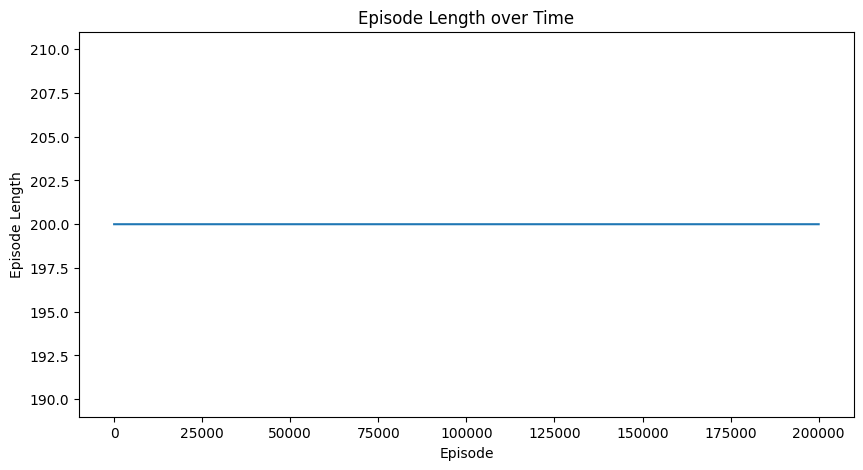

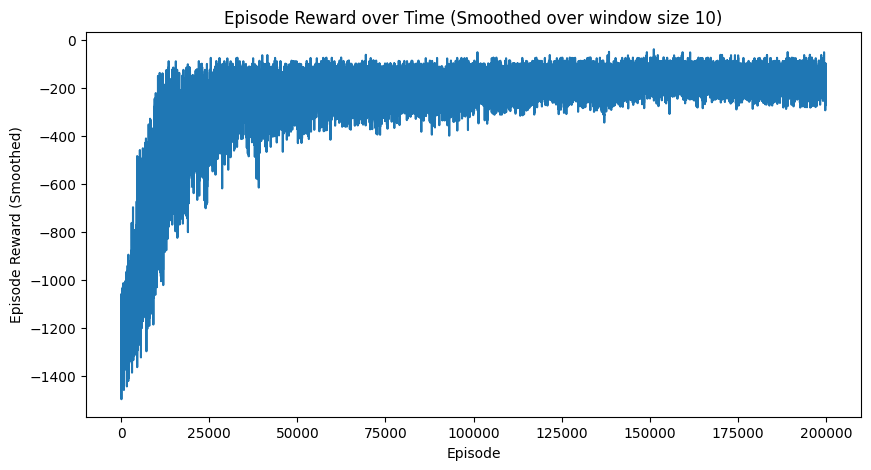

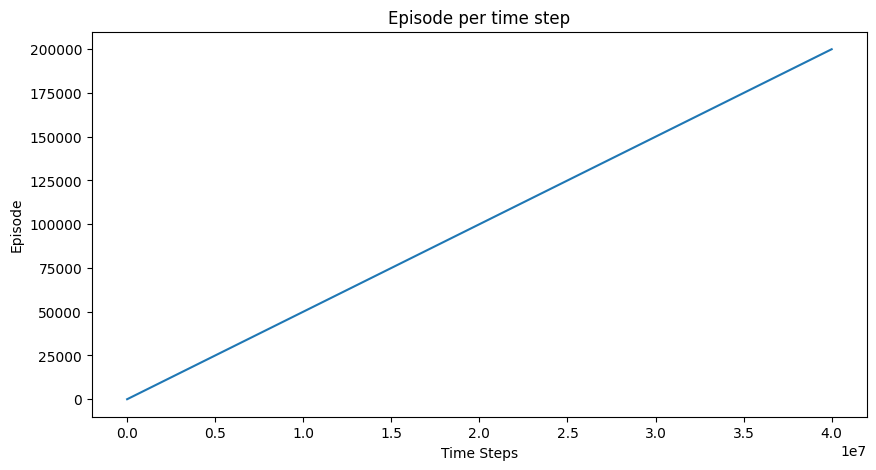

Visualizing Enhanced Value Function...


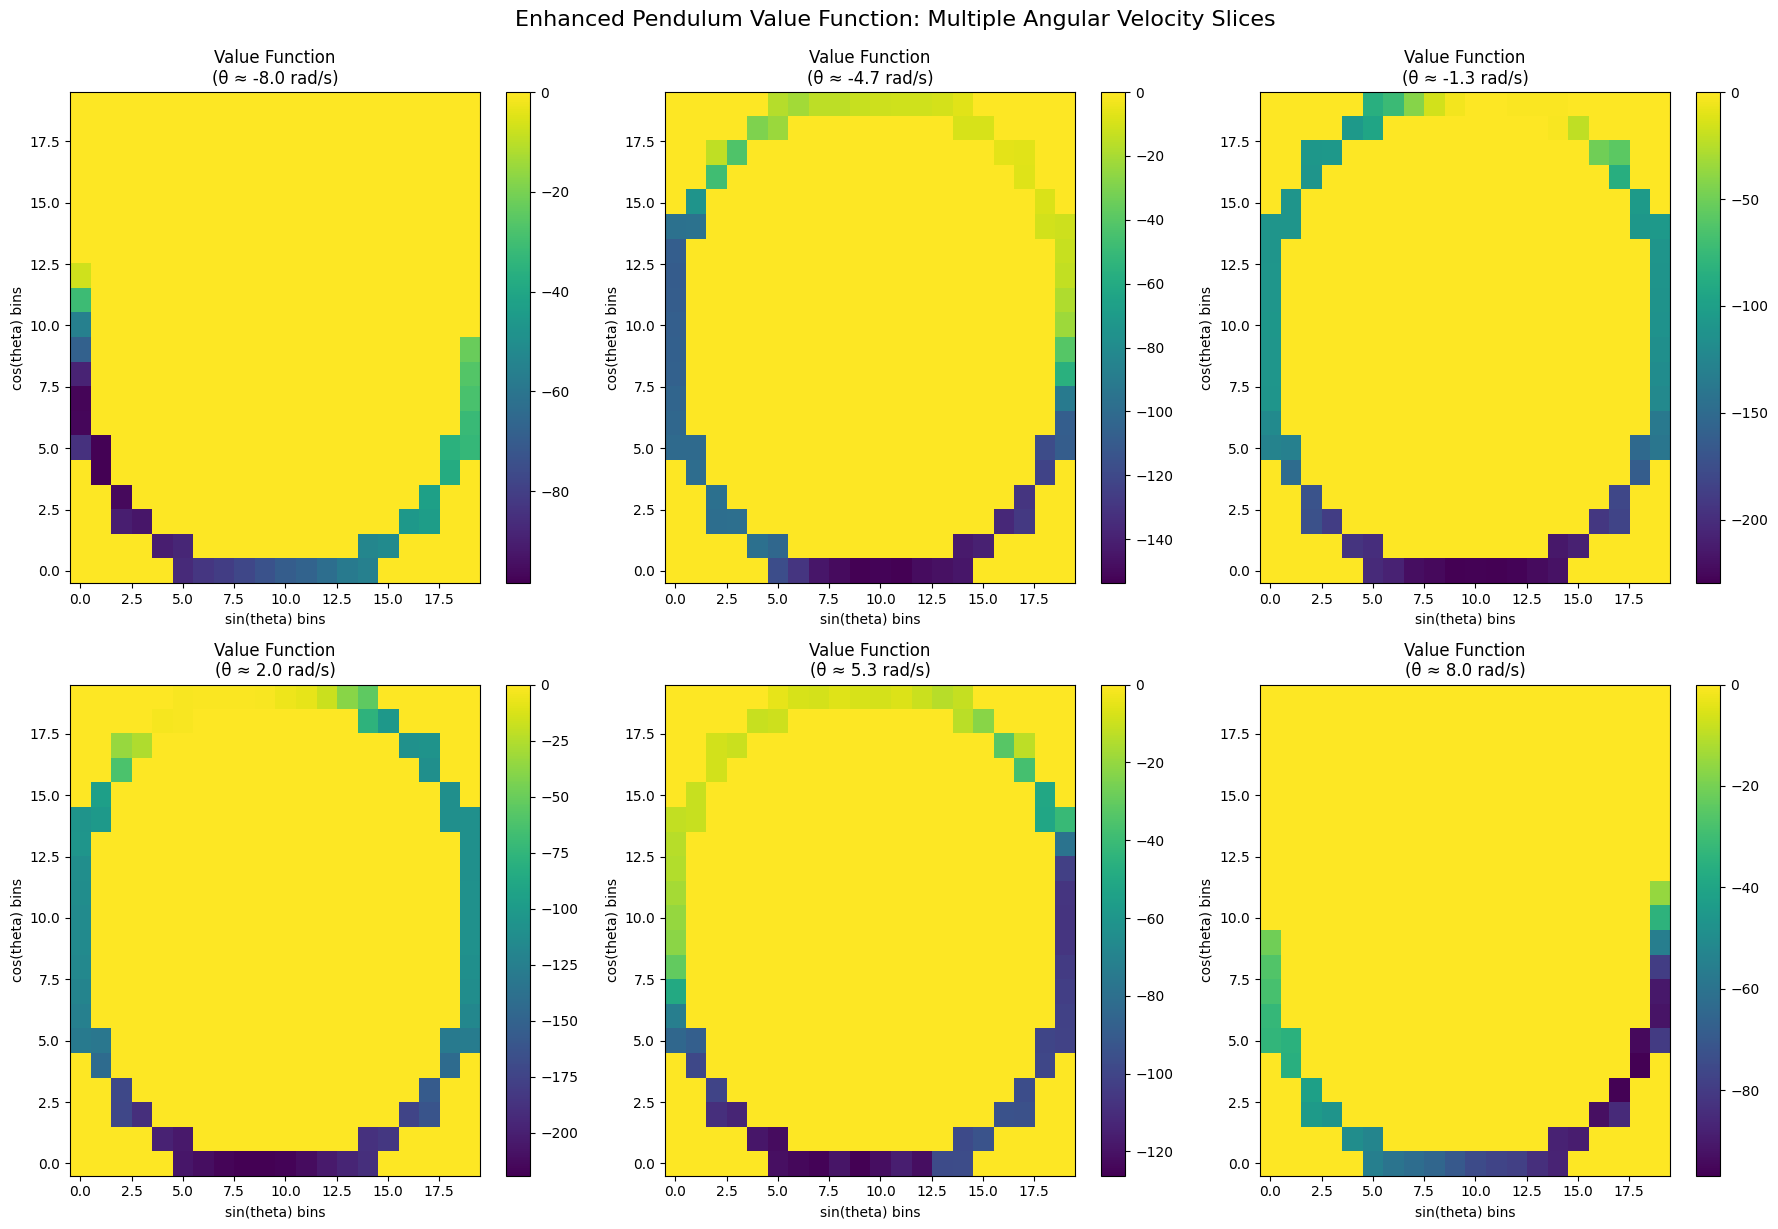

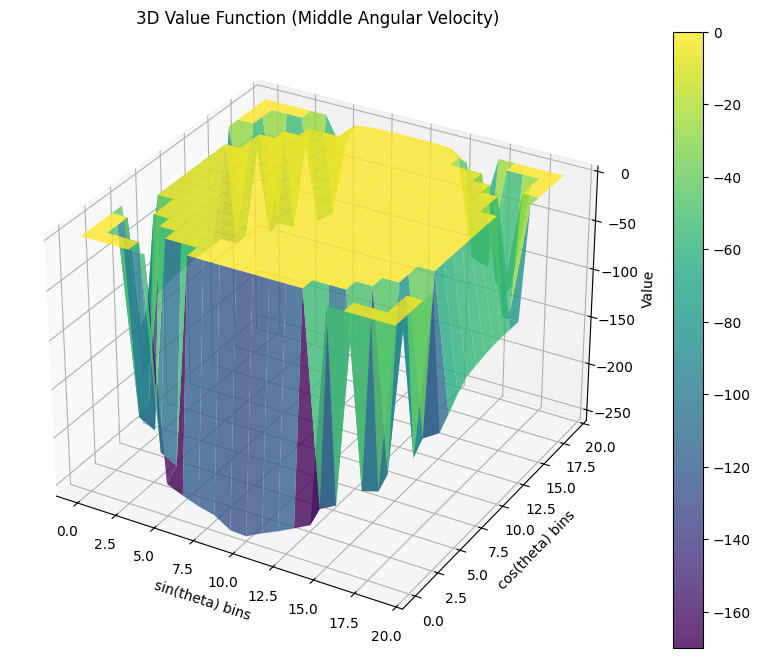

Visualizing Policy Distribution...


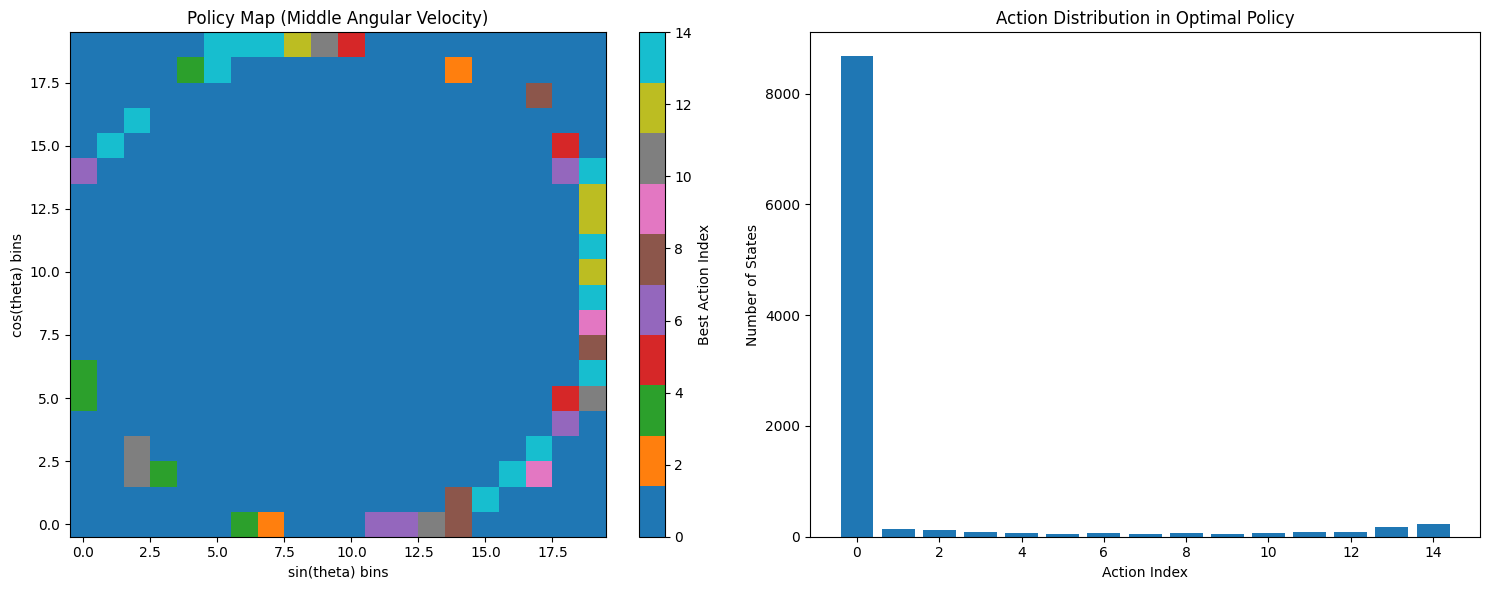

In [138]:
# Plot training statistics for enhanced model
if 'training_stats' in locals():
    plot_episode_stats(training_stats)

# Extract value function from Q-table (max Q-value for each state)
if 'Q_table' in locals():
    V_QL = np.max(Q_table, axis=1)

def plot_enhanced_pendulum_values(V, cos_bins=20, sin_bins=20, theta_dot_bins=25):
    """
    Plot value function for the enhanced discretized Pendulum environment.
    Shows multiple 2D heatmaps for different angular velocity ranges.
    """
    # Reshape V to 3D: [cos_theta_bins, sin_theta_bins, theta_dot_bins]
    V_3d = V.reshape(cos_bins, sin_bins, theta_dot_bins)

    # Create subplots for different theta_dot slices
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Select 6 different theta_dot slices to visualize
    theta_dot_slices = [0, theta_dot_bins//5, 2*theta_dot_bins//5,
                       3*theta_dot_bins//5, 4*theta_dot_bins//5, theta_dot_bins-1]

    for idx, theta_dot_slice in enumerate(theta_dot_slices):
        V_2d = V_3d[:, :, theta_dot_slice]

        im = axes[idx].imshow(V_2d, cmap='viridis', origin='lower', aspect='auto')
        axes[idx].set_xlabel('sin(theta) bins')
        axes[idx].set_ylabel('cos(theta) bins')

        # Calculate actual theta_dot value for this slice
        theta_dot_value = -8.0 + (theta_dot_slice / (theta_dot_bins - 1)) * 16.0
        axes[idx].set_title(f'Value Function\n(θ̇ ≈ {theta_dot_value:.1f} rad/s)')

        plt.colorbar(im, ax=axes[idx])

    plt.tight_layout()
    plt.suptitle('Enhanced Pendulum Value Function: Multiple Angular Velocity Slices',
                 fontsize=16, y=1.02)
    plt.show()

    # Create a 3D visualization of the most interesting slice
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Use the middle theta_dot slice
    middle_slice = theta_dot_bins // 2
    V_2d = V_3d[:, :, middle_slice]

    X, Y = np.meshgrid(range(sin_bins), range(cos_bins))
    surf = ax.plot_surface(X, Y, V_2d, cmap='viridis', alpha=0.8)

    ax.set_xlabel('sin(theta) bins')
    ax.set_ylabel('cos(theta) bins')
    ax.set_zlabel('Value')
    ax.set_title('3D Value Function (Middle Angular Velocity)')

    plt.colorbar(surf)
    plt.show()

def plot_policy_distribution(Q, cos_bins=20, sin_bins=20, theta_dot_bins=25):
    """
    Visualize the policy distribution across different state dimensions.
    """
    # Get the best action for each state
    best_actions = np.argmax(Q, axis=1)

    # Reshape to 3D
    policy_3d = best_actions.reshape(cos_bins, sin_bins, theta_dot_bins)

    # Plot policy for middle theta_dot slice
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    middle_slice = theta_dot_bins // 2
    policy_2d = policy_3d[:, :, middle_slice]

    im1 = ax1.imshow(policy_2d, cmap='tab10', origin='lower', aspect='auto')
    ax1.set_xlabel('sin(theta) bins')
    ax1.set_ylabel('cos(theta) bins')
    ax1.set_title('Policy Map (Middle Angular Velocity)')
    plt.colorbar(im1, ax=ax1, label='Best Action Index')

    # Plot action distribution histogram
    action_counts = np.bincount(best_actions, minlength=Q.shape[1])
    ax2.bar(range(len(action_counts)), action_counts)
    ax2.set_xlabel('Action Index')
    ax2.set_ylabel('Number of States')
    ax2.set_title('Action Distribution in Optimal Policy')

    plt.tight_layout()
    plt.show()

# Visualize the enhanced value function and policy
if 'V_QL' in locals():
    print("Visualizing Enhanced Value Function...")
    plot_enhanced_pendulum_values(V_QL, cos_bins=20, sin_bins=20, theta_dot_bins=25)

if 'Q_table' in locals():
    print("Visualizing Policy Distribution...")
    plot_policy_distribution(Q_table, cos_bins=20, sin_bins=20, theta_dot_bins=25)

### Simulating the Optimal Pendulum Control Policy

To visualize how the trained Q-Learning agent performs on the Pendulum task, we'll simulate the environment and generate videos showing:
- **Pendulum swing-up behavior** from different initial positions
- **Control smoothness** achieved through high-resolution discretization  
- **Balancing performance** near the inverted position

In [139]:
# Simulate the environment using the optimal policy from Enhanced Q-Learning and display the video

if 'Q_table' in locals():
    simulate_and_show_video_pendulum(Q_table, epsilon=0.0,
                                   cos_bins=20, sin_bins=20, theta_dot_bins=25, n_actions=15)
else:
    print("Please run the training cell first to generate Q_table")

Enhanced State Space: 20 × 20 × 25 = 10,000 states
Action Space: 15 discrete actions
Starting simulation with 10,000 state space...
Simulation completed: 200 steps, Total reward: -126.54
